

*   https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis/notebook



In [26]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)
Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.3.0)


In [9]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [12]:
dataset_path='/content/drive/MyDrive/DataSet/twitter_sentiment_analysis.csv'

In [13]:
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [14]:
print("Dataset size:", len(df))


Dataset size: 1600000


In [16]:
print(df[0:4])

   target  ...                                               text
0       0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  ...  is upset that he can't update his Facebook by ...
2       0  ...  @Kenichan I dived many times for the ball. Man...
3       0  ...    my whole body feels itchy and like its on fire 

[4 rows x 6 columns]


In [17]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [18]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 478 ms, sys: 6.74 ms, total: 485 ms
Wall time: 485 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

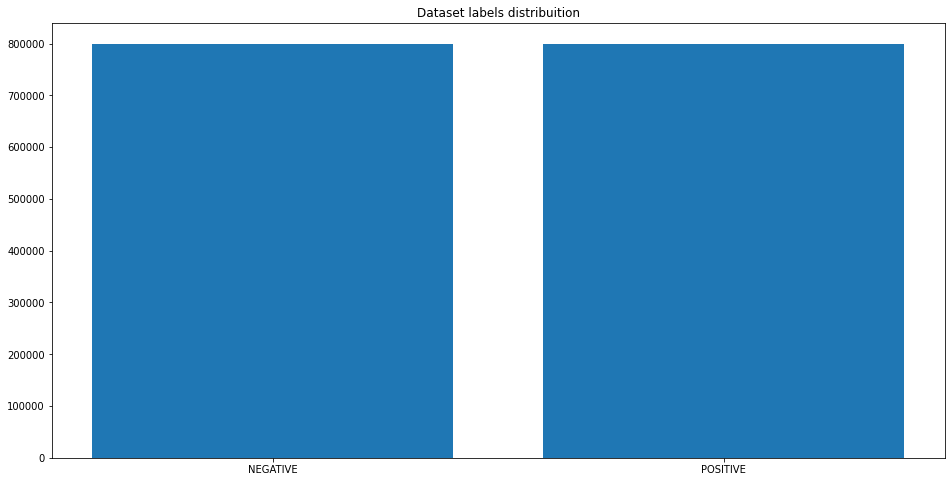

In [19]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [21]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

In [22]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [23]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.67 s, sys: 330 ms, total: 3 s
Wall time: 3 s


In [31]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2021-07-16 05:41:38,356 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-07-16T05:41:38.356332', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [32]:
w2v_model.build_vocab(documents)

2021-07-16 05:41:58,747 : INFO : collecting all words and their counts
2021-07-16 05:41:58,750 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-16 05:41:58,776 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2021-07-16 05:41:58,803 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2021-07-16 05:41:58,826 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2021-07-16 05:41:58,849 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2021-07-16 05:41:58,872 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2021-07-16 05:41:58,892 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2021-07-16 05:41:58,921 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2021-07-16 05:41:58,946 : INFO : PROGRESS: at s

In [34]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [35]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-07-16 05:44:08,384 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7', 'datetime': '2021-07-16T05:44:08.384350', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-07-16 05:44:09,417 : INFO : EPOCH 1 - PROGRESS: at 5.21% examples, 421196 words/s, in_qsize 14, out_qsize 0
2021-07-16 05:44:10,463 : INFO : EPOCH 1 - PROGRESS: at 10.42% examples, 415165 words/s, in_qsize 15, out_qsize 0
2021-07-16 05:44:11,467 : INFO : EPOCH 1 - PROGRESS: at 15.73% examples, 421595 words/s, in_qsize 14, out_qsize 4
2021-07-16 05:44:12,489 : INFO : EPOCH 1 - PROGRESS: at 21.79% examples, 438130 words/s, in_qsize 16, out_qsize 1
2021-07-16 05:44:13,559 : INFO : EPOCH 1 - PROGRESS: at 27.32% examples, 435389 words/s, in_qsize 16, out_qsize 0
2021-07-16 05:44:14,563 : INFO : EPOC

CPU times: user 18min 53s, sys: 5.54 s, total: 18min 59s
Wall time: 9min 45s


(263126287, 295270528)

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419


In [37]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 24.3 s, sys: 891 ms, total: 25.2 s
Wall time: 24.8 s


In [38]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [39]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [40]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)
y_train[:10]

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [41]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [42]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [43]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-07-16 05:55:10,696 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [44]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [45]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 728s 627ms/step - loss: 0.5269 - accuracy: 0.7321 - val_loss: 0.4659 - val_accuracy: 0.7802


2021-07-16 06:07:32,604 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 2/8
1125/1125 [==============================] - 690s 613ms/step - loss: 0.4803 - accuracy: 0.7667 - val_loss: 0.4576 - val_accuracy: 0.7845


2021-07-16 06:19:02,259 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 3/8
1125/1125 [==============================] - 678s 602ms/step - loss: 0.4727 - accuracy: 0.7711 - val_loss: 0.4539 - val_accuracy: 0.7883


2021-07-16 06:30:19,931 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 4/8
1125/1125 [==============================] - 667s 593ms/step - loss: 0.4674 - accuracy: 0.7746 - val_loss: 0.4516 - val_accuracy: 0.7888


2021-07-16 06:41:27,279 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 5/8
1125/1125 [==============================] - 669s 595ms/step - loss: 0.4643 - accuracy: 0.7768 - val_loss: 0.4513 - val_accuracy: 0.7896


2021-07-16 06:52:36,456 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 6/8
1125/1125 [==============================] - 661s 588ms/step - loss: 0.4628 - accuracy: 0.7784 - val_loss: 0.4491 - val_accuracy: 0.7899


2021-07-16 07:03:37,877 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 7/8
1125/1125 [==============================] - 657s 584ms/step - loss: 0.4620 - accuracy: 0.7782 - val_loss: 0.4467 - val_accuracy: 0.7907


2021-07-16 07:14:34,935 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 8/8
 104/1125 [=>............................] - ETA: 9:38 - loss: 0.4567 - accuracy: 0.7800

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 